In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.optim as optim
from tensorflow.keras import layers, models
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
from torchvision.models import vgg16
from torchvision.ops import roi_align
import pandas as pd
from PIL import Image
from skimage.feature import hog
from skimage import io
from skimage.transform import resize
from skimage.segmentation import felzenszwalb
from skimage import graph
from skimage.measure import regionprops
import os

In [2]:
!python -m pip install torch==2.1.2 torchvision==0.16.2 sympy==1.12
!python -m pip install "numpy<2"


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import torchvision
import sympy
print(torch.__version__)
print(torchvision.__version__)
print(sympy.__version__)

2.1.2+cpu
0.16.2+cpu
1.12


In [70]:
# Rutas a los archivos

madison_nudo_5_2_defectos=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\MADISON_Nudo5\MADISON_Nudo5-2\Defectos"
madison_nudo_5_2_no_defectos= r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\MADISON_Nudo5\MADISON_Nudo5-2\No defectos" 

madison_nudo_5_1_defectos=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\MADISON_Nudo5\MADISON_Nudo5-1\Defectos"
madison_nudo_5_1_no_defectos= r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\MADISON_Nudo5\MADISON_Nudo5-1\No defectos"

Scinova_defectos=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\SCINOVA_a_clasificar\Defectos"
Scinova_no_defectos=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\SCINOVA_a_clasificar\No defectos"

Madison_Biobam_sin_defectos_1=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\MADISON_Biobam_SinDefectos-1"
Madison_Biobam_sin_defectos_2=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\MADISON_Biobam_SinDefectos-2"
Madison_Biobam_sin_defectos_3=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\MADISON_Biobam_SinDefectos-3"


Probetas_defectos_1=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\Defectos\DED_308L_EST1_defectos"
Probetas_defectos_2=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\Defectos\DED_308L_EST2_DEFECTOS"
Probeta_defectos_3=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\Defectos\DED_308L_EST3_Defectos"
Probetas_defectos_4=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\Defectos\ENG_208_EST3_defectos"
Probeta_defectos_5=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\Defectos\ENG_308L_EST2_defectos"

Probeta_no_defectos=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\No defectos"

validacion_defectos=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\Defectos Validacion"
validacion_no_defectos=r"C:\Users\unidad-epa\Desktop\Iker\Scripts\Clasificados Material 1\Modelo 2 intento\No defectos Validacion"


In [71]:
from PIL import Image, UnidentifiedImageError

# Definimos una función para recortar las imágenes y eliminar los bordes.

def recortar_bordes(imagen, margen=0.05):
    alto, ancho = imagen.size
    x1 = int(ancho*margen)
    y1 = int(alto*margen)
    x2 = int(ancho*(1-margen))
    y2 = int(alto*(1-margen))
    return imagen.crop((x1, y1, x2, y2))

# Función paara procesar las imágenes, utilizando la función anterior de recorte


def procesar_imagenes(ruta, image_size):
    contenedor = []
    extensiones_validas = ('.jpg', '.jpeg', '.png', '.tif', '.tiff')
    for archivo in os.listdir(ruta):
        if not archivo.lower().endswith(extensiones_validas):
            continue  # Salta archivos que no son imágenes
        nombre_archivo = os.path.join(ruta, archivo)
        try:
            imagen = Image.open(nombre_archivo)
            if imagen.mode != 'RGB':
                imagen = imagen.convert('RGB')
            imagen = recortar_bordes(imagen)  # Recorta los bordes de la imagen
            imagen = imagen.resize(image_size)
            
            contenedor.append(imagen)
        except (UnidentifiedImageError, OSError):
            print(f"Archivo no válido o corrupto: {nombre_archivo}")
            continue
    contenedor = np.array(contenedor) / 255
    return np.array(contenedor)

In [72]:
madison_nudo_5_2_defectos_np = procesar_imagenes(madison_nudo_5_2_defectos, (256, 256))
madison_nudo_5_2_no_defectos_np = procesar_imagenes(madison_nudo_5_2_no_defectos, (256, 256))
madison_nudo_5_1_defectos_np = procesar_imagenes(madison_nudo_5_1_defectos, (256, 256))
madison_nudo_5_1_no_defectos_np = procesar_imagenes(madison_nudo_5_1_no_defectos, (256, 256))
scinova_defectos_np = procesar_imagenes(Scinova_defectos, (256, 256))
scinova_no_defectos_np = procesar_imagenes(Scinova_no_defectos, (256, 256))
madison_biobam_sin_defectos_1_np = procesar_imagenes(Madison_Biobam_sin_defectos_1, (256, 256))
madison_biobam_sin_defectos_2_np = procesar_imagenes(Madison_Biobam_sin_defectos_2, (256, 256))
madison_biobam_sin_defectos_3_np = procesar_imagenes(Madison_Biobam_sin_defectos_3, (256, 256))

probetas_defectos_1_np = procesar_imagenes(Probetas_defectos_1, (256, 256))
probetas_defectos_2_np = procesar_imagenes(Probetas_defectos_2, (256, 256))
probetas_defectos_3_np = procesar_imagenes(Probeta_defectos_3, (256, 256))
probetas_defectos_4_np = procesar_imagenes(Probetas_defectos_4, (256, 256))
probetas_defectos_5_np = procesar_imagenes(Probeta_defectos_5, (256, 256))
probetas_no_defectos_np = procesar_imagenes(Probeta_no_defectos, (256, 256))

validacion_defectos_np = procesar_imagenes(validacion_defectos, (256, 256))
validacion_no_defectos_np = procesar_imagenes(validacion_no_defectos, (256, 256))


In [7]:
probetas_defectos_5_np.shape

(114, 256, 256, 3)

Vamos a ver la cantidad de datos que tenemos de cada pieza.

In [73]:
madison_no_defectos=np.concatenate((madison_biobam_sin_defectos_2_np, madison_biobam_sin_defectos_3_np), axis=0) # el uno erstá en validación

madison_nudo_defectos=np.concatenate((madison_nudo_5_2_defectos_np, madison_nudo_5_1_defectos_np), axis=0)
madison_nudo_no_defectos=np.concatenate((madison_nudo_5_2_no_defectos_np, madison_nudo_5_1_no_defectos_np), axis=0)

probetas_defectos=np.concatenate((probetas_defectos_1_np, probetas_defectos_2_np, probetas_defectos_3_np, probetas_defectos_4_np, probetas_defectos_5_np), axis=0)

print('Tamaño de madison_nudo_defectos:', madison_nudo_defectos.shape)
print('Tamaño de madison_nudo_no_defectos:', madison_nudo_no_defectos.shape)

print('Tamaño de madison_no_defectos:', madison_no_defectos.shape)
print('Tamaño de scinova_defectos:', scinova_defectos_np.shape)
print('Tamaño de scinova_no_defectos:', scinova_no_defectos_np.shape)
print('Tamaño de probetas_defectos:', probetas_defectos.shape)
print('Tamaño de probetas_no_defectos:', probetas_no_defectos_np.shape)
print('Tamaño de validacion_defectos:', validacion_defectos_np.shape)
print('Tamaño de validacion_no_defectos:', validacion_no_defectos_np.shape)

Tamaño de madison_nudo_defectos: (247, 256, 256, 3)
Tamaño de madison_nudo_no_defectos: (69, 256, 256, 3)
Tamaño de madison_no_defectos: (550, 256, 256, 3)
Tamaño de scinova_defectos: (27, 256, 256, 3)
Tamaño de scinova_no_defectos: (82, 256, 256, 3)
Tamaño de probetas_defectos: (332, 256, 256, 3)
Tamaño de probetas_no_defectos: (1159, 256, 256, 3)
Tamaño de validacion_defectos: (191, 256, 256, 3)
Tamaño de validacion_no_defectos: (178, 256, 256, 3)


In [74]:
X = np.concatenate((probetas_defectos, madison_nudo_5_2_defectos_np, scinova_defectos_np, madison_nudo_no_defectos, probetas_no_defectos_np,  madison_no_defectos), axis=0)
y = np.concatenate((np.ones(probetas_defectos.shape[0]), np.ones(madison_nudo_5_2_defectos_np.shape[0]), np.ones(scinova_defectos_np.shape[0]), np.zeros(madison_nudo_no_defectos.shape[0]), np.zeros(probetas_no_defectos_np.shape[0]), np.zeros(madison_no_defectos.shape[0])), axis=0)

X_validacion=np.concatenate((validacion_defectos_np, madison_nudo_5_1_defectos_np, madison_biobam_sin_defectos_1_np, validacion_no_defectos_np), axis=0)
y_validacion=np.concatenate((np.ones(validacion_defectos_np.shape[0]), np.ones(madison_nudo_5_1_defectos_np.shape[0]), np.zeros(madison_biobam_sin_defectos_1_np.shape[0]), np.zeros(validacion_no_defectos_np.shape[0])), axis=0)

1: Modelo preentrenado

VGG16

Entrenamiento con los datos en bruto, sin hacer balanceos ni aumento de datos

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

# --- Preprocesamiento ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Convierte tus arrays numpy a tensores y aplica el preprocesamiento
X_tensor = torch.stack([transform(Image.fromarray((img*255).astype('uint8'))) for img in X])
y_tensor = torch.tensor(y, dtype=torch.long)

# Dataset y DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# --- Modelo VGG16 ---
model = vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)  # 2 clases
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# --- Entrenamiento ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):  # Ajusta el número de épocas
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(loader):.4f}")
    


c:\Users\unidad-epa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\unidad-epa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.1411
Epoch 2, Loss: 0.0368
Epoch 3, Loss: 0.0396
Epoch 4, Loss: 0.1033
Epoch 5, Loss: 0.0346
Epoch 6, Loss: 0.0403


KeyboardInterrupt: 

In [ ]:
# Prepara el DataLoader de validación
X_val_tensor = torch.stack([transform(Image.fromarray((img*255).astype('uint8'))) for img in X_validacion])
y_val_tensor = torch.tensor(y_validacion, dtype=torch.long)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Validación

model.eval()
val_loss = 0.0
correct=0
total=0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Validacion - Loss:{val_loss/len(val_loader):.4f}, Accuracy: { correct / total:.2f}%')

c:\Users\unidad-epa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validacion - Loss:0.2354, Accuracy: 0.96%


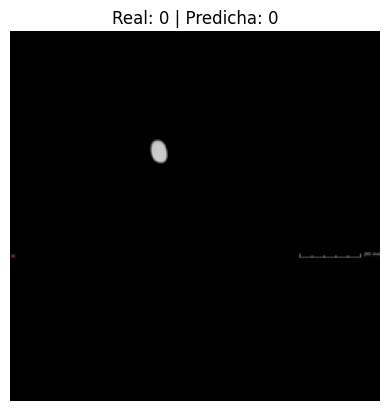

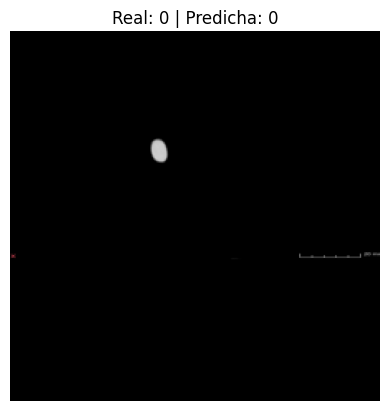

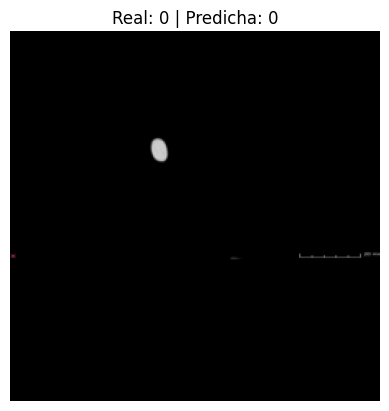

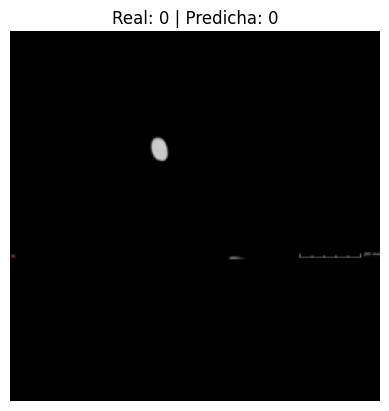

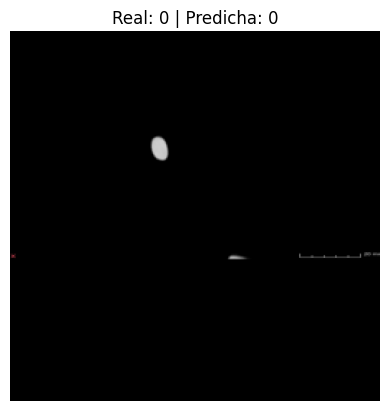

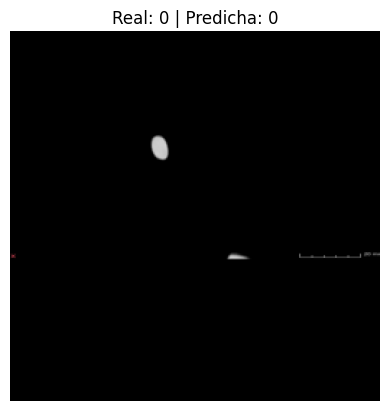

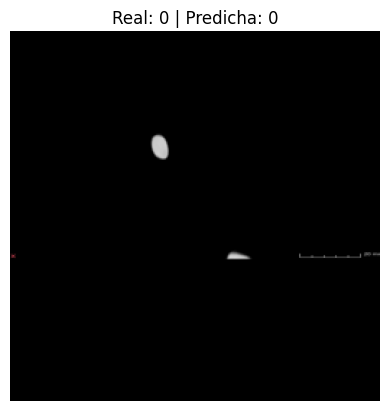

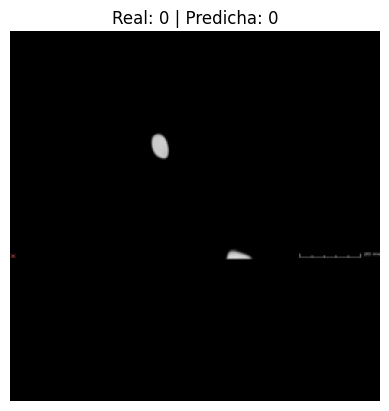

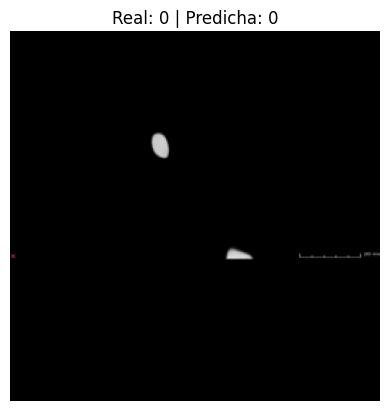

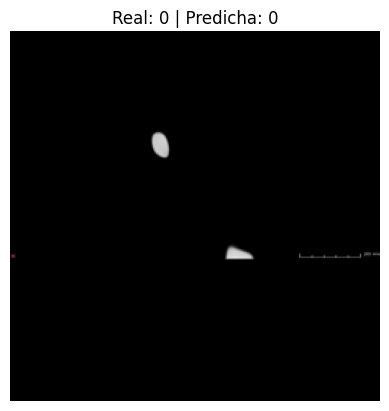

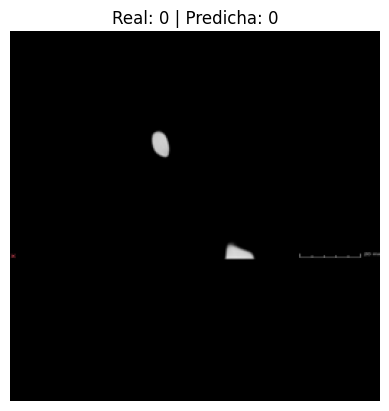

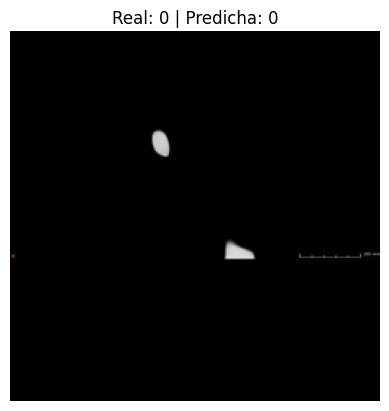

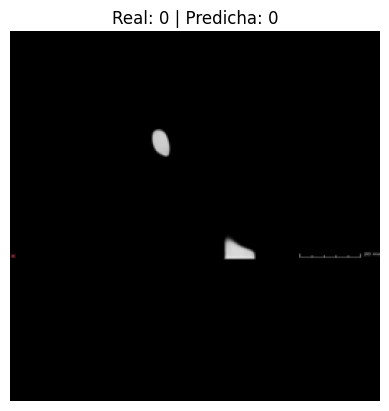

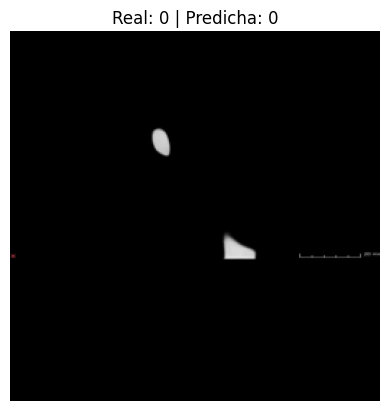

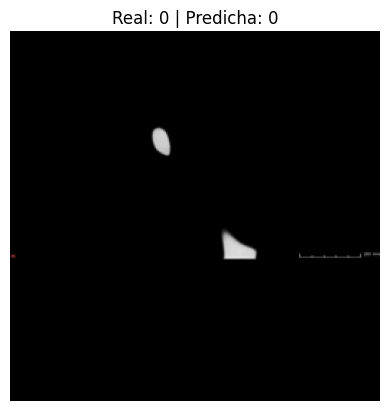

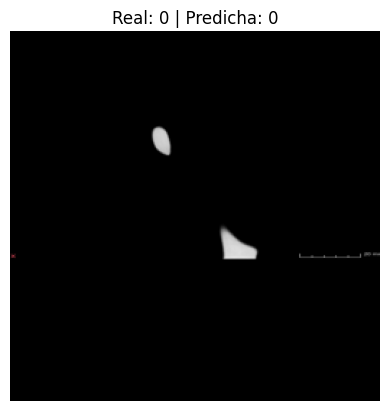

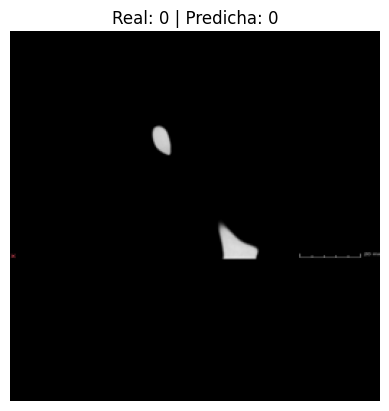

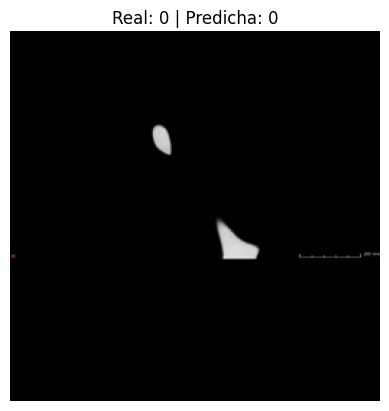

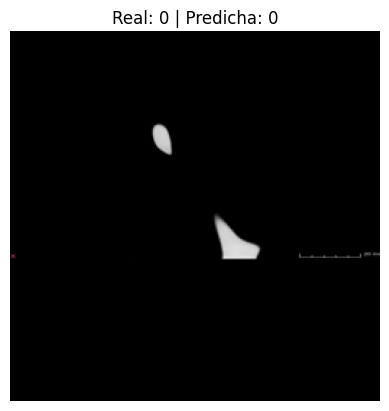

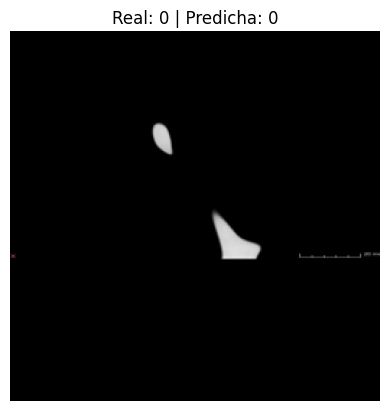

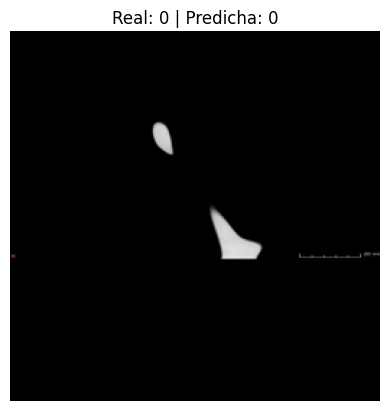

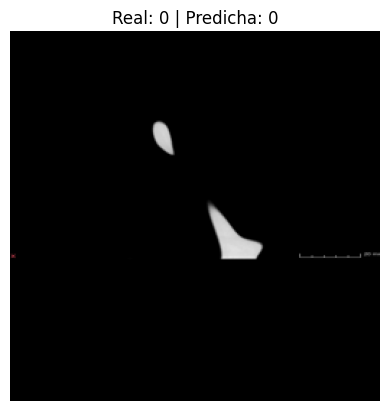

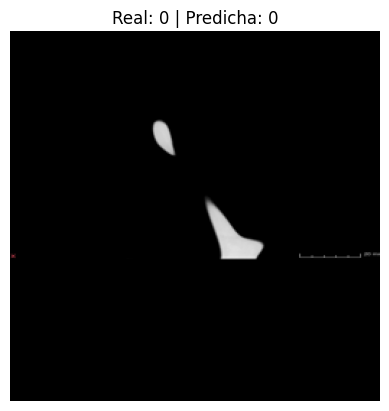

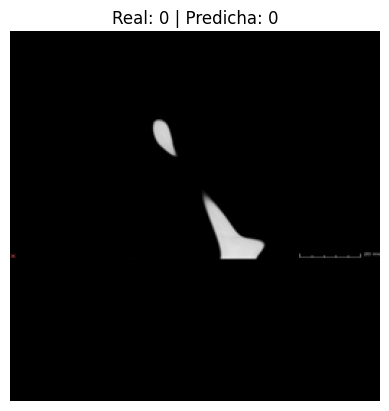

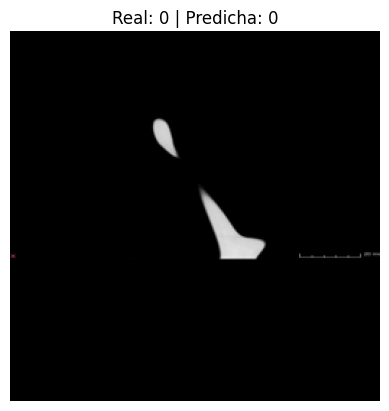

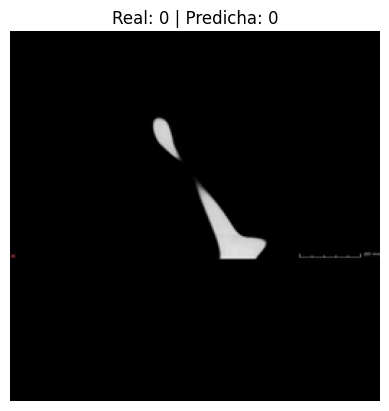

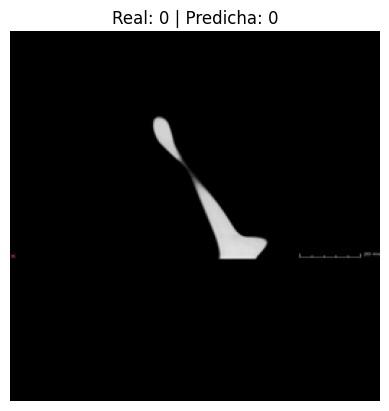

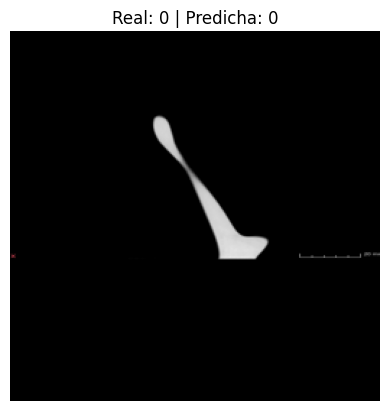

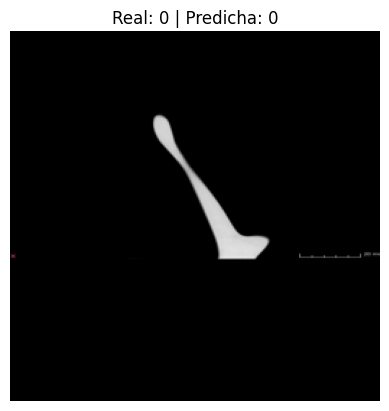

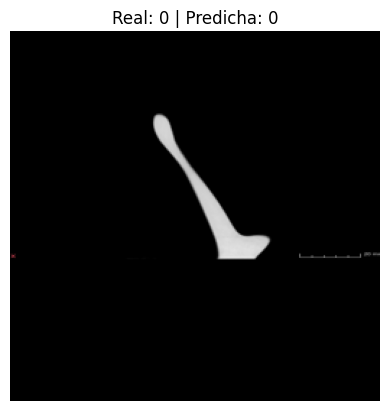

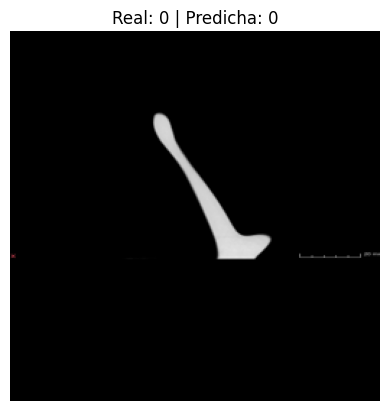

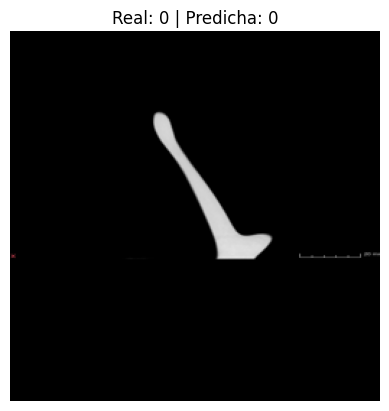

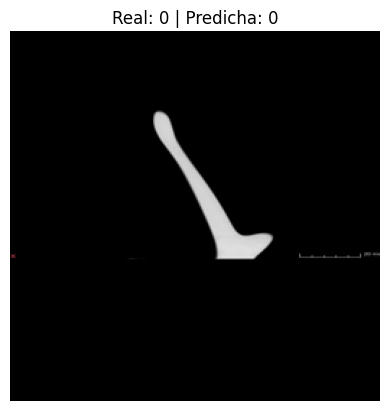

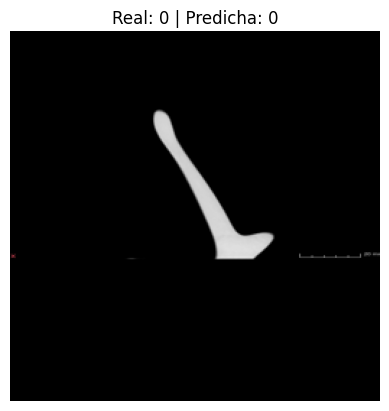

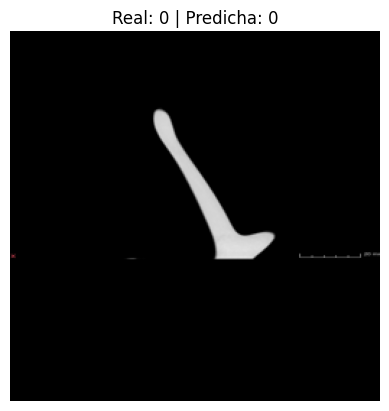

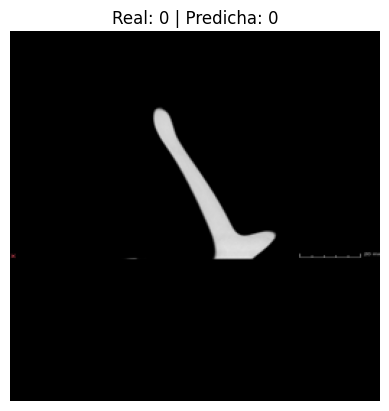

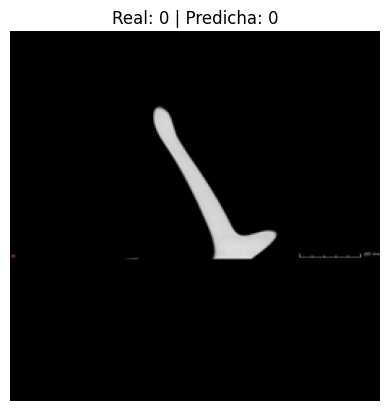

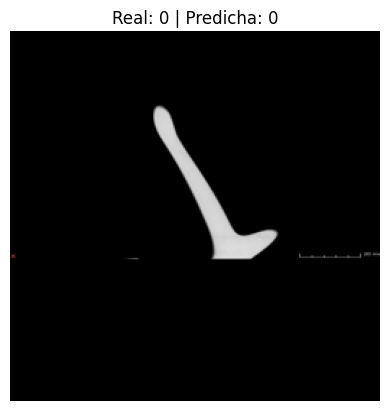

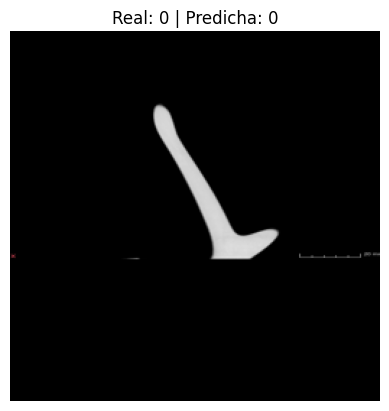

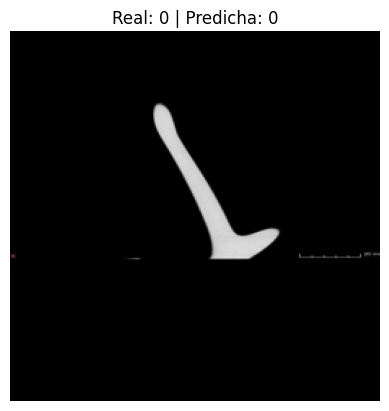

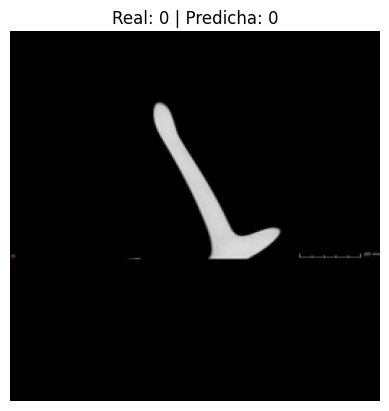

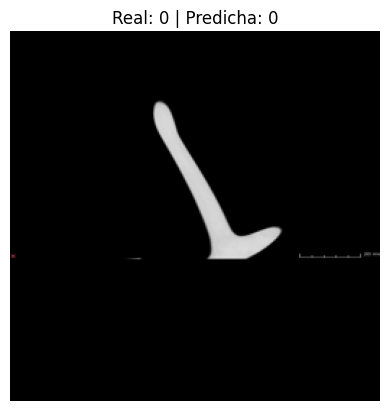

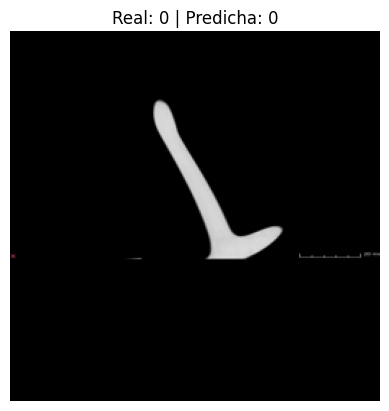

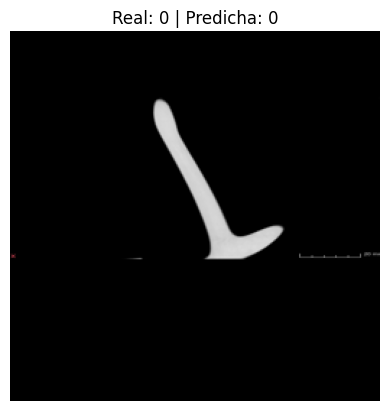

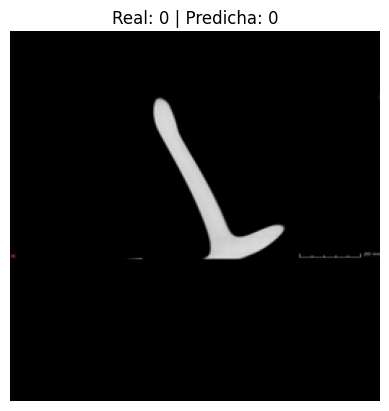

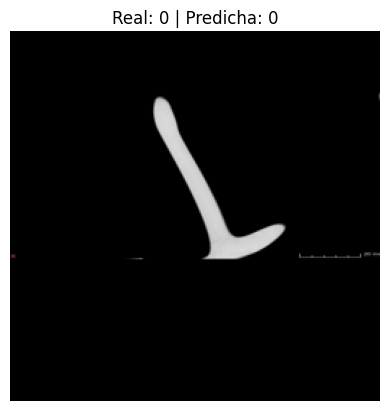

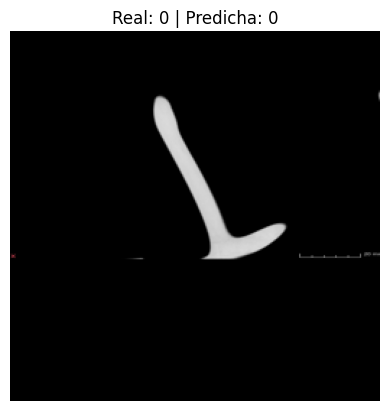

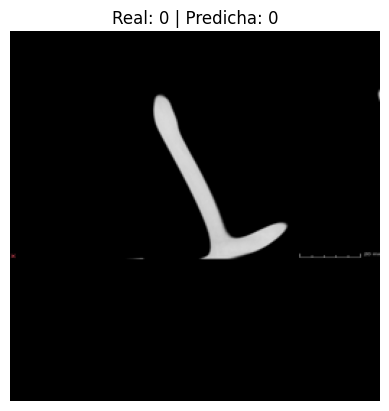

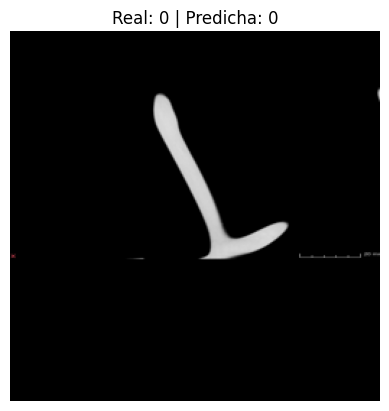

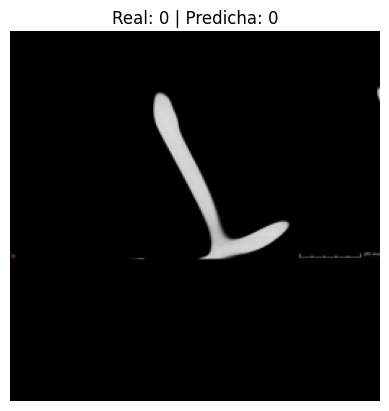

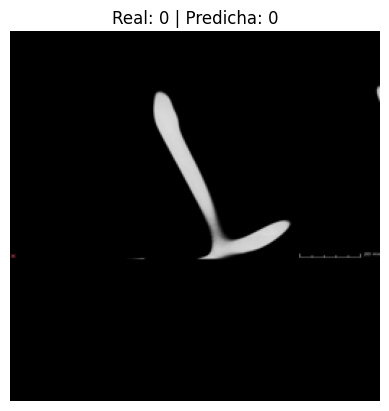

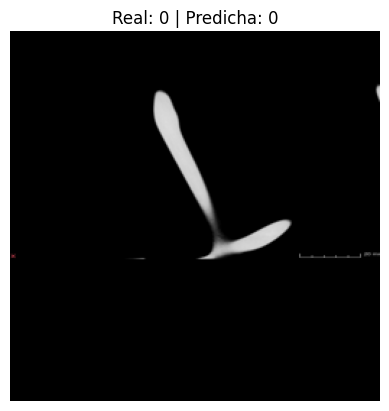

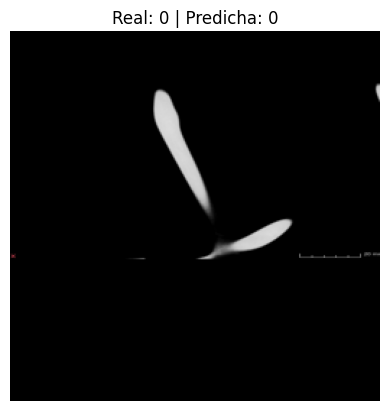

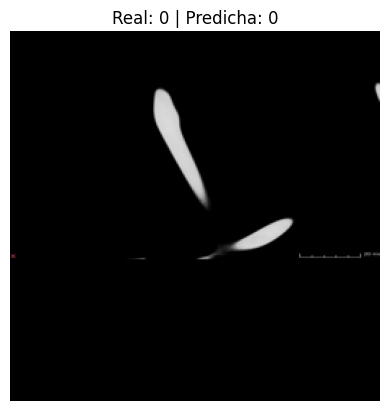

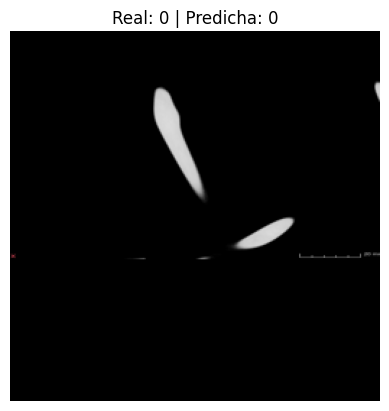

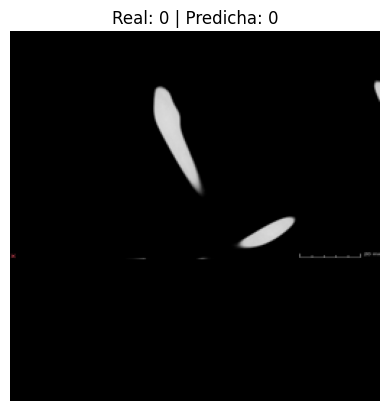

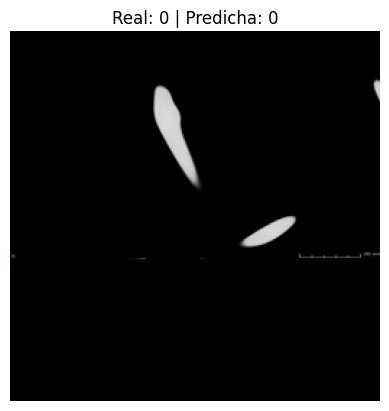

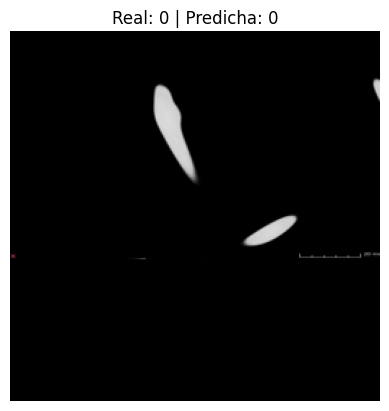

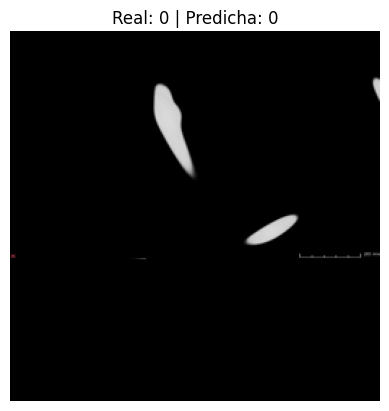

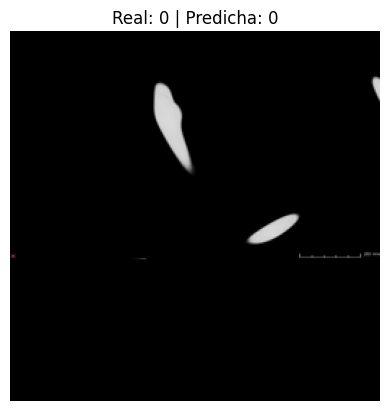

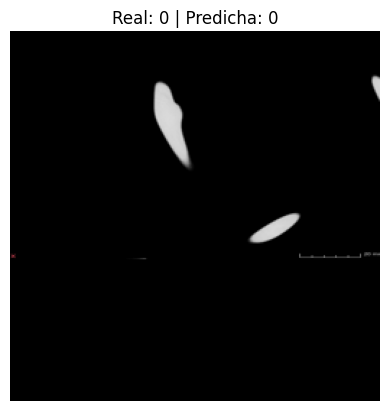

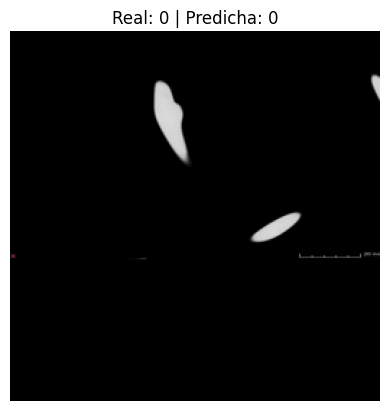

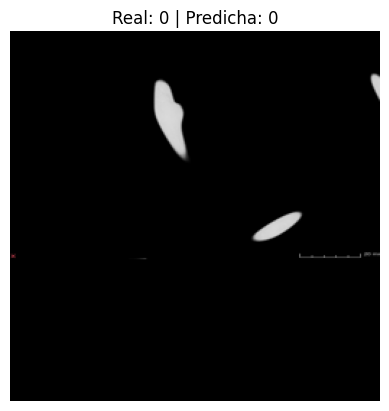

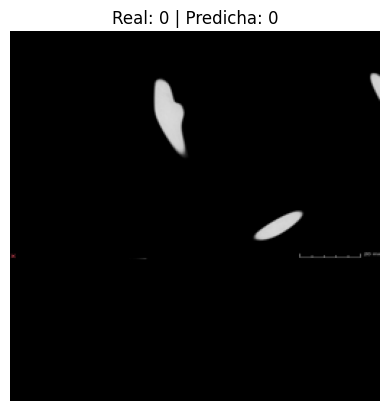

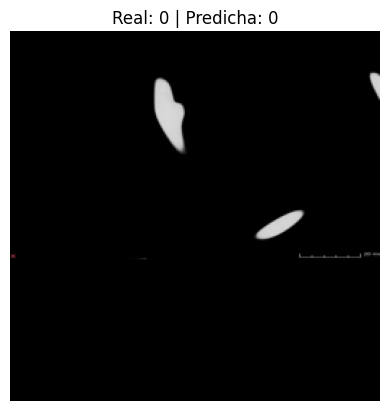

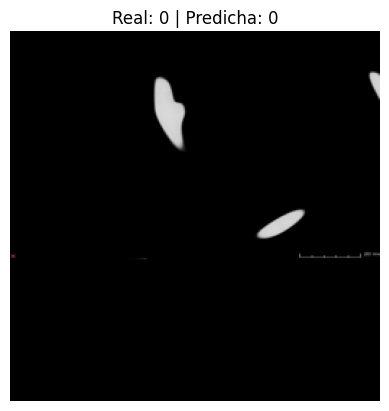

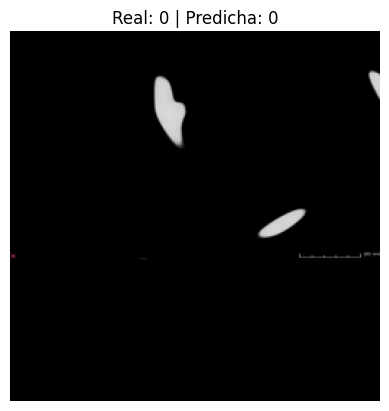

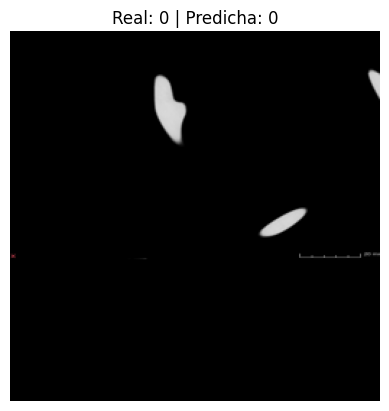

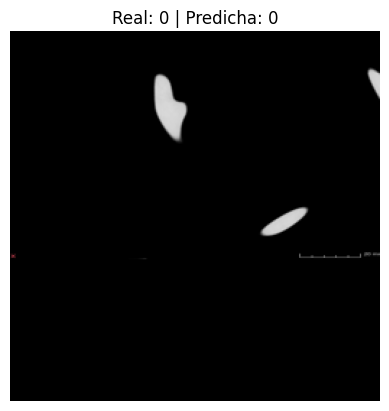

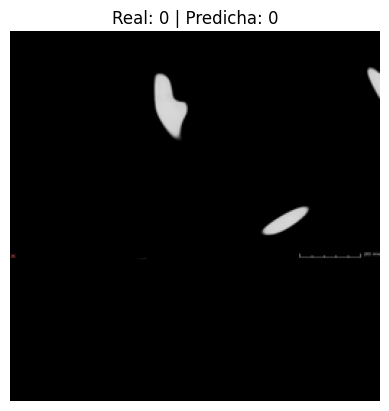

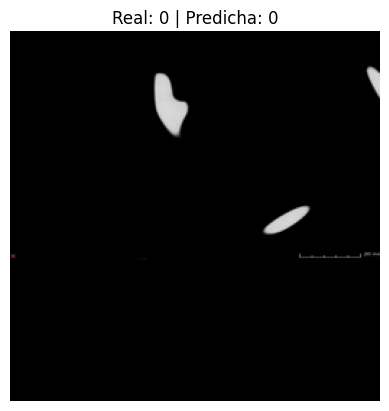

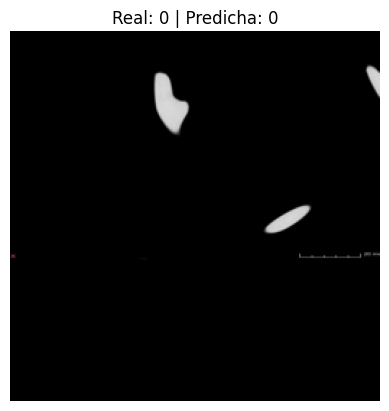

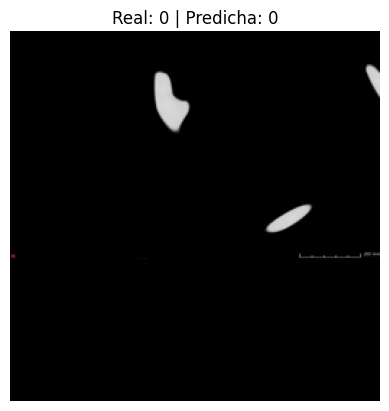

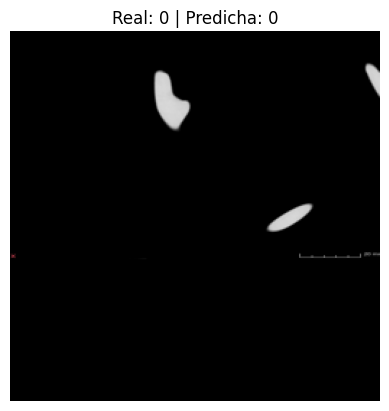

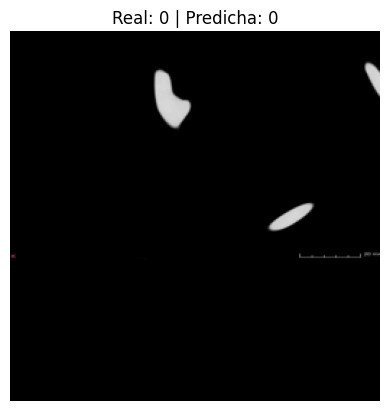

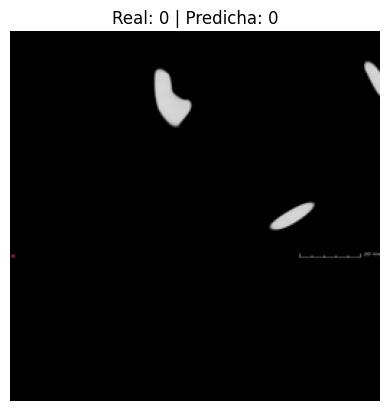

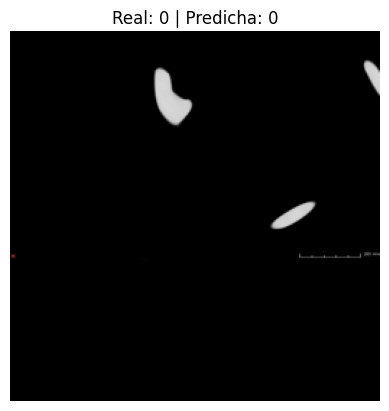

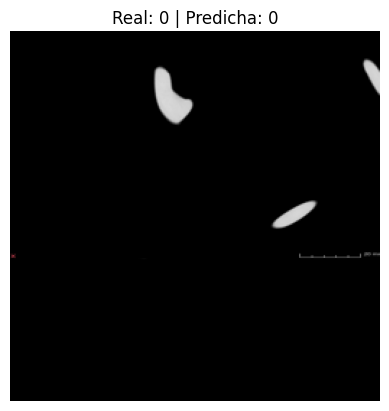

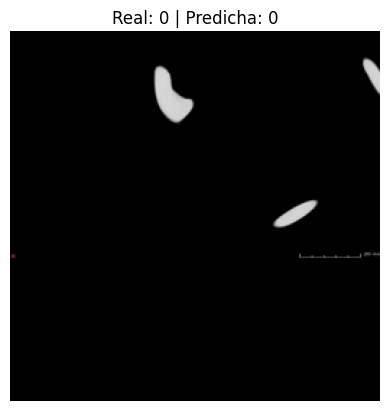

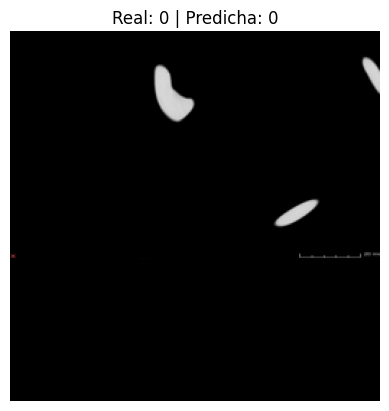

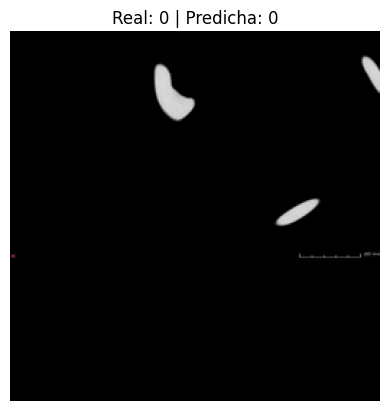

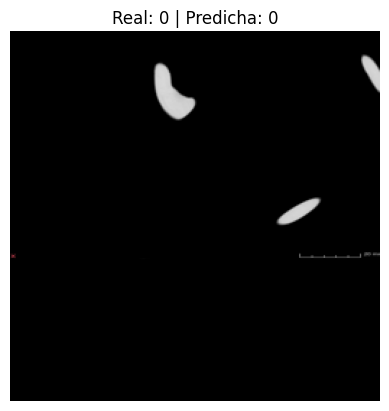

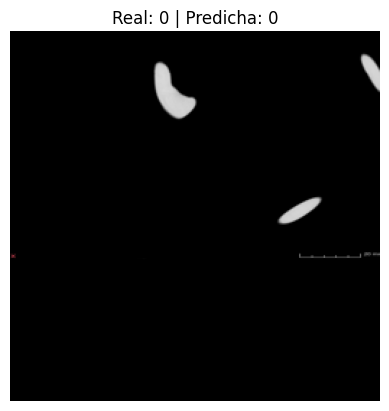

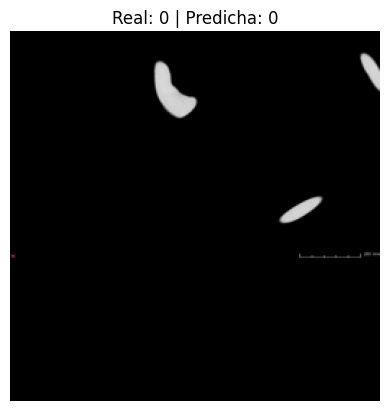

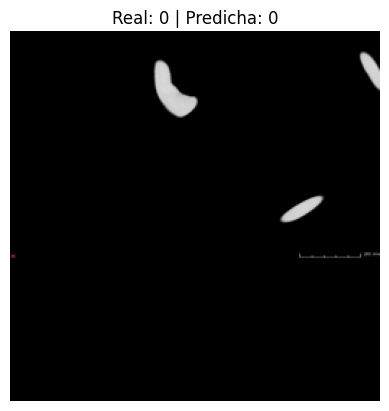

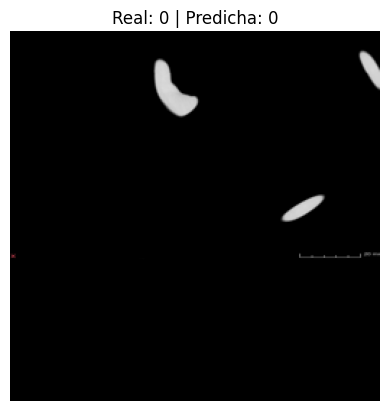

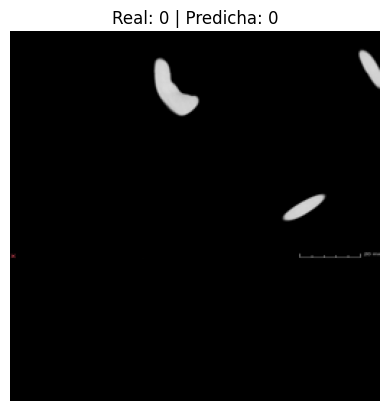

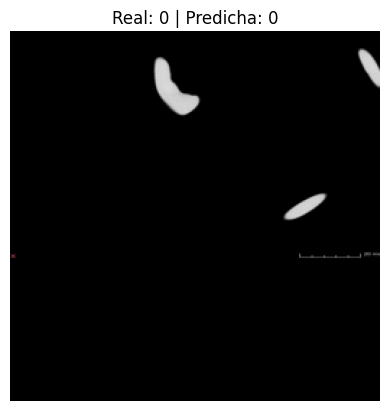

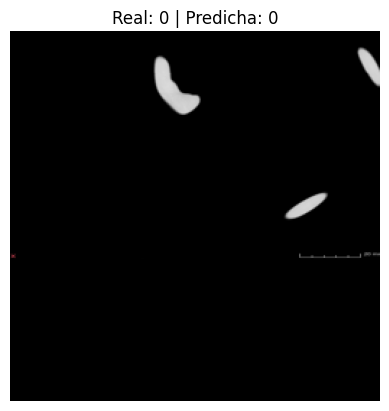

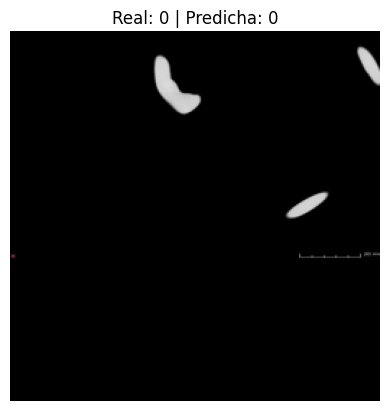

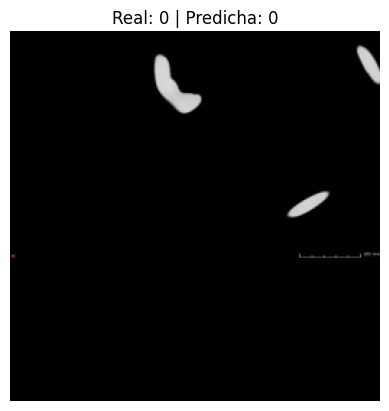

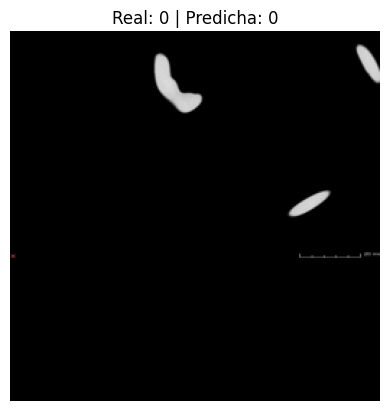

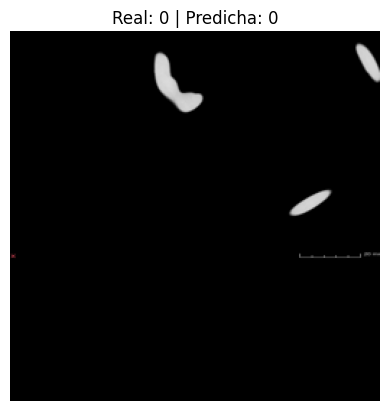

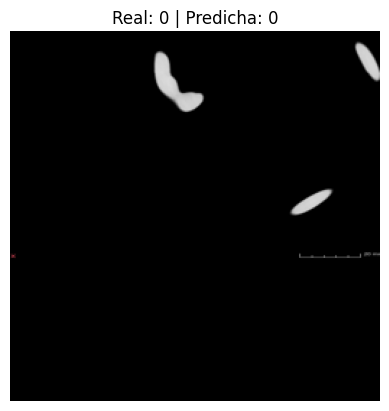

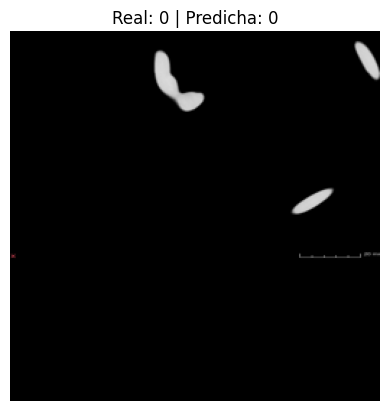

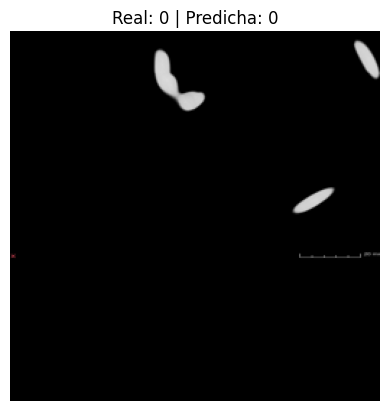

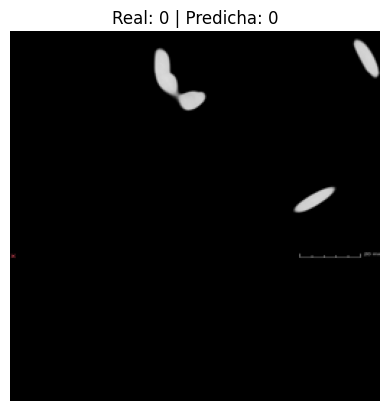

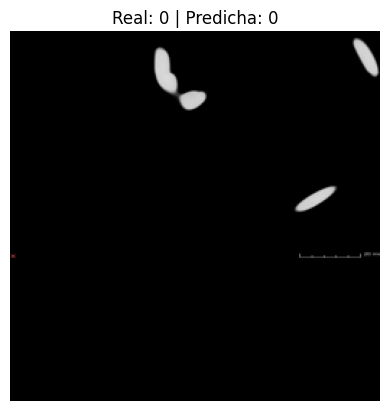

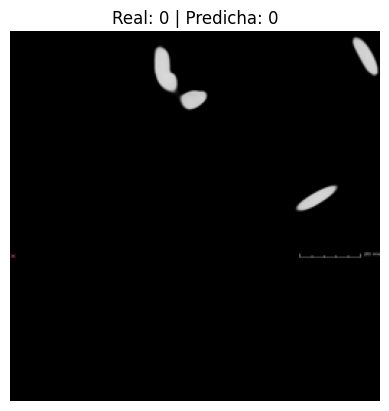

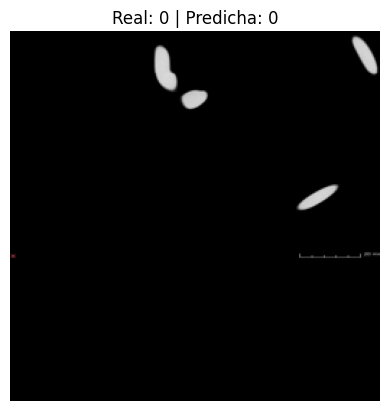

In [62]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i in range(500,600):  # Visualiza las 5 primeras imágenes del conjunto de validación
        img = X_validacion[i]
        label = y_validacion[i]
        img_pil = Image.fromarray((img*255).astype('uint8'))
        img_tensor = transform(img_pil).unsqueeze(0).to(device)
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
        plt.imshow(img)
        plt.title(f"Real: {int(label)} | Predicha: {pred}")
        plt.axis('off')
        plt.show()

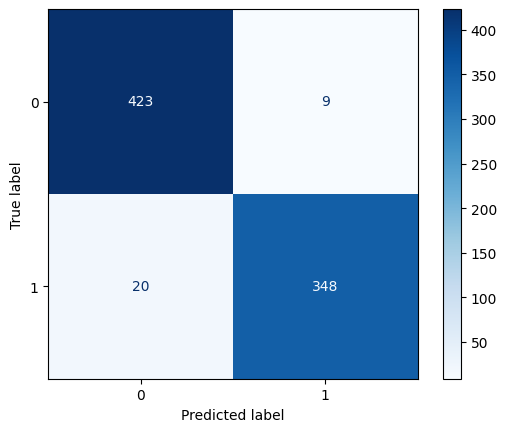

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obtén todas las predicciones y etiquetas reales
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for i in range(len(X_validacion)):
        img = X_validacion[i]
        label = y_validacion[i]
        img_pil = Image.fromarray((img*255).astype('uint8'))
        img_tensor = transform(img_pil).unsqueeze(0).to(device)
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
        y_true.append(int(label))
        y_pred.append(pred)

# Calcula y muestra la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

Vamos a ver si nos dice donde estan los fallos

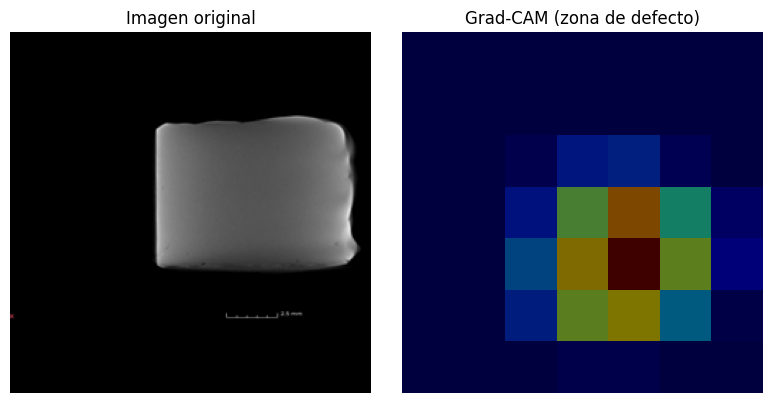

In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import vgg16
from torchvision import transforms
from PIL import Image

def grad_cam(model, img_tensor, target_class):
    model.eval()
    features = []
    gradients = []

    def save_features_hook(module, input, output):
        features.append(output)
    def save_gradients_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Hook en la última capa convolucional
    h1 = model.features[-1].register_forward_hook(save_features_hook)
    h2 = model.features[-1].register_full_backward_hook(save_gradients_hook)

    output = model(img_tensor)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # Grad-CAM
    grads_val = gradients[0].cpu().data.numpy()[0]
    fmap = features[0].cpu().data.numpy()[0]
    weights = np.mean(grads_val, axis=(1, 2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    h1.remove()
    h2.remove()
    return cam

# --- USO ---
# Prepara la imagen igual que en el entrenamiento
img = Image.fromarray((X_validacion[75]*255).astype('uint8'))
img_tensor = transform(img).unsqueeze(0).to(device)

# Predice la clase
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

# Obtén el mapa Grad-CAM
cam = grad_cam(model, img_tensor, pred_class)

# Visualiza
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Imagen original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Grad-CAM (zona de defecto)')
plt.axis('off')
plt.tight_layout()
plt.show()

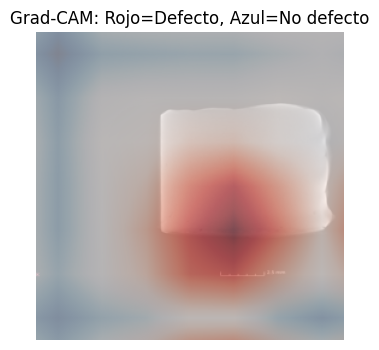

In [69]:
# Obtén los dos mapas Grad-CAM
cam_defecto = grad_cam(model, img_tensor, target_class=1)  # 1 = defecto
cam_no_defecto = grad_cam(model, img_tensor, target_class=0)  # 0 = no defecto

# Normaliza ambos mapas
cam_defecto = cam_defecto / (cam_defecto.max() + 1e-8)
cam_no_defecto = cam_no_defecto / (cam_no_defecto.max() + 1e-8)

# Redimensiona los mapas al tamaño de la imagen
from skimage.transform import resize
cam_defecto_resized = resize(cam_defecto, img.size[::-1], preserve_range=True)
cam_no_defecto_resized = resize(cam_no_defecto, img.size[::-1], preserve_range=True)

# Visualiza ambos mapas superpuestos
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.imshow(cam_no_defecto_resized, cmap='Blues', alpha=0.5)  # Azul: no defecto
plt.imshow(cam_defecto_resized, cmap='Reds', alpha=0.5)      # Rojo: defecto
plt.title('Grad-CAM: Rojo=Defecto, Azul=No defecto')
plt.axis('off')
plt.show()